## 探索数据

### 导入数据
通过 Pandas 库从数据集文件分别导入数据至 `data_train`、`data_test` 和 `data_store` 三个数据帧（_DataFrame_），即训练集、测试集和商店补充数据集。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

sns.set(style='whitegrid', palette='muted')

data_train = pd.read_csv('data/train.csv',
                         dtype={
                             'StateHoliday': 'category',
                             'SchoolHoliday': 'category'},
                         parse_dates=['Date'])
data_test = pd.read_csv('data/test.csv',
                        dtype={
                            'StateHoliday': 'category',
                            'SchoolHoliday': 'category'},
                        parse_dates=['Date'])
data_store = pd.read_csv('data/store.csv',
                         dtype={
                             'StoreType': 'category',
                             'Assortment': 'category',
                             'CompetitionOpenSinceMonth': float,
                             'CompetitionOpenSinceYear': float,
                             'Promo2': float,
                             'Promo2SinceWeek': float,
                             'Promo2SinceYear': float})

### 检查数据

为方便分析，通过 _Store_ 字段索引联合合并 `data_train` 与 `data_store` 数据集到同一数据集中。合并后的 `data_train` 包含原有字段以及对应的商店信息。

In [3]:
data_train = pd.merge(data_train, data_store, on='Store', how='left')
data_train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0.0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0.0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0.0,NaN,NaN,NaN


#### 缺失值和异常值
输出并观察训练集 `data_train` 的基本信息和统计量：

In [4]:
print('Total number of samples:', data_train.shape[0])
print('')
data_train.info()
print('')
print(data_train.iloc[:, 1:].describe())

Total number of samples: 1017209

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null category
SchoolHoliday                1017209 non-null category
StoreType                    1017209 non-null category
Assortment                   1017209 non-null category
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null float64
Promo2SinceWeek              509178 non-null f

Missing value counts:
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


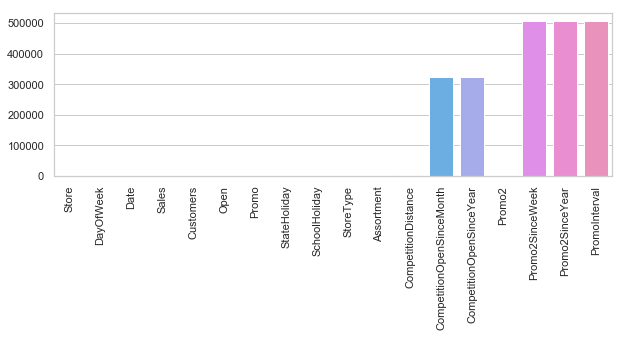

In [5]:
counts = data_train.isnull().sum()
print('Missing value counts:')
print(counts)
plt.figure(figsize=(10, 3))
g = sns.barplot(counts.index, counts.values)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

训练集 `data_train` 共包含 1017209 个数据样本。若干字段存在数据缺失情况：_CompetitionDistance_, _CompetitionOpenSinceMonth_, _CompetitionOpenSinceYear_, _Promo2SinceWeek_, _Promo2SinceYear_ 和 _PromoInterval_。其中 _CompetitionDistance_ 为连续数值变量，可通过均值补全缺失数据。由于该项目将采用 XGBoost 构建模型，默认情况下 XGBoost 支持缺失值（树算法在训练期间学习缺失值的分叉方向），可令 XGBoost 自动处理其它分类变量的缺失数据。

绘制 _Sales_、_Customers_ 和 _CompetitionDistance_ 的频率直方图和箱线图：

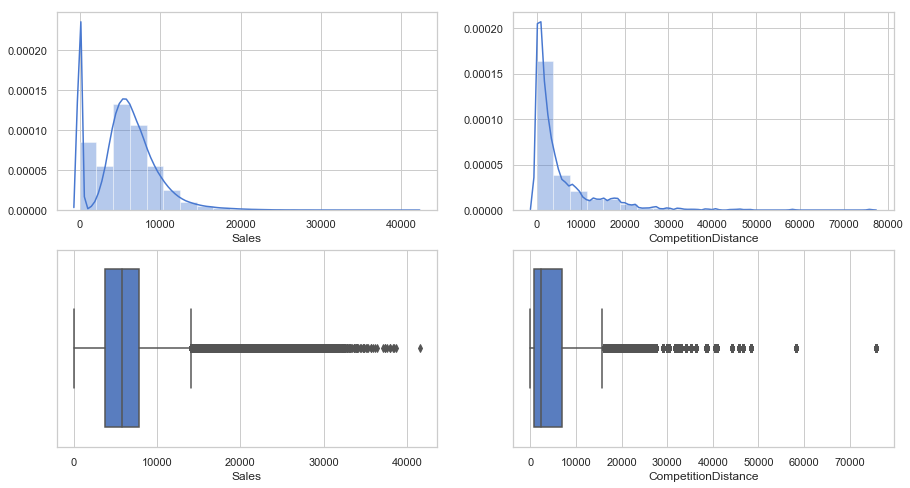

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.distplot(data_train['Sales'].dropna(), bins=20, ax=axes[0][0]);
sns.distplot(data_train['CompetitionDistance'].dropna(), bins=20, ax=axes[0][1]);
sns.boxplot(x=data_train['Sales'].dropna(), ax=axes[1][0])
sns.boxplot(x=data_train['CompetitionDistance'].dropna(), ax=axes[1][1])
plt.show()

从上图可发现在 _Sales_、_Customers_ 和 _CompetitionDistance_ 三个字段均存在异常值。 

### 可视化数据

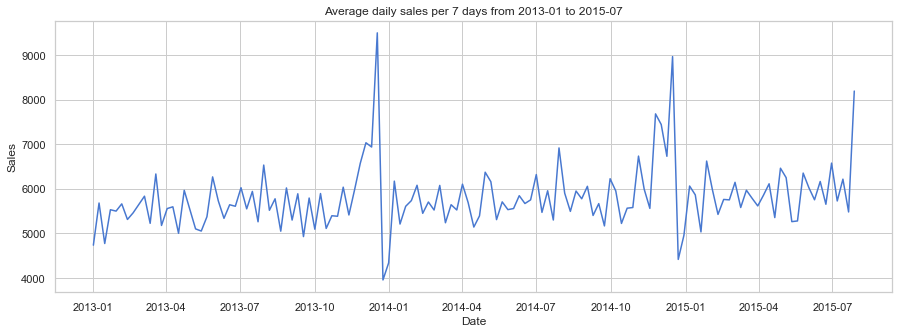

In [7]:
plt.figure(figsize=(15, 5))
data_train_sales = data_train[['Date', 'Sales']]
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax = sns.lineplot(x=data_train_sales_1.index, y=data_train_sales_1['Sales'])
ax.set_title('Average daily sales per 7 days from 2013-01 to 2015-07')
plt.show()

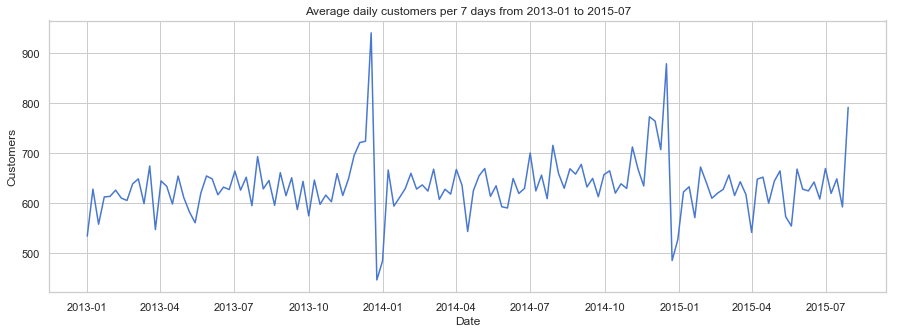

In [8]:
plt.figure(figsize=(15, 5))
data_train_customers = data_train[['Date', 'Customers']]
data_train_customers_1 = data_train_customers.groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax = sns.lineplot(x=data_train_customers_1.index, y=data_train_customers_1['Customers'])
ax.set_title('Average daily customers per 7 days from 2013-01 to 2015-07')
plt.show()

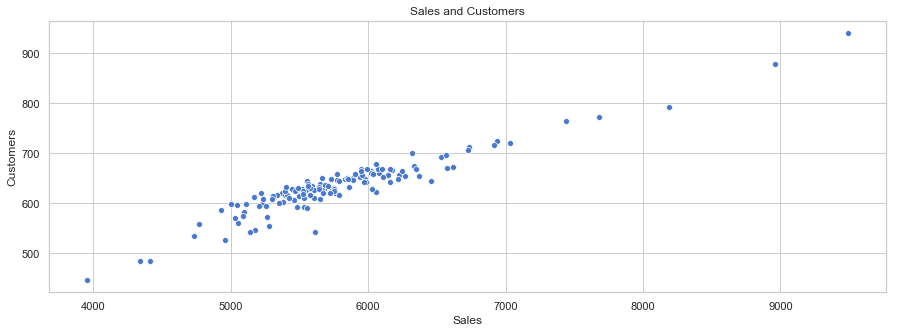

In [9]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=data_train_sales_1['Sales'], y=data_train_customers_1['Customers']).set_title('Sales and Customers')
plt.show()

In [10]:
data_train_open_sl_cstm = data_train[['Sales', 'Customers']]
data_train_open_sl_cstm.corr()

,Sales,Customers
Sales,1.000000,0.894711
Customers,0.894711,1.000000


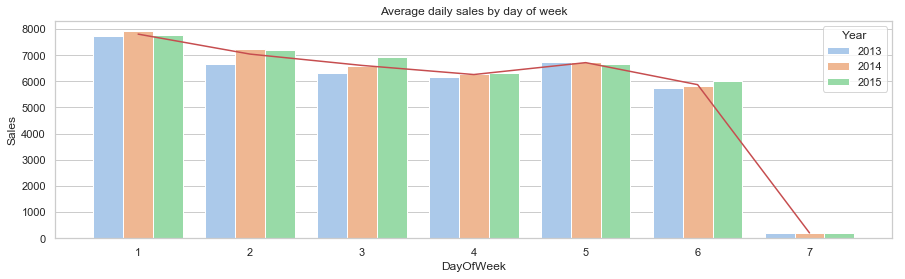

In [11]:
plt.figure(figsize=(15, 4))
data_train_wd = data_train.copy()
data_train_wd['Year'] = data_train_wd['Date'].dt.strftime('%Y')
data_train_wd = data_train_wd.groupby(['Year', 'DayOfWeek']).mean().reset_index()
sns.barplot(x='DayOfWeek', y='Sales', hue='Year', palette='pastel', data=data_train_wd)
data_train_wd = data_train_wd.groupby(['DayOfWeek']).mean().reset_index()
ax = sns.lineplot(x=data_train_wd.index, y=data_train_wd['Sales'], color='#c64d4f')
ax.set_title('Average daily sales by day of week')
ax.legend_.set_title('Year')
plt.show()

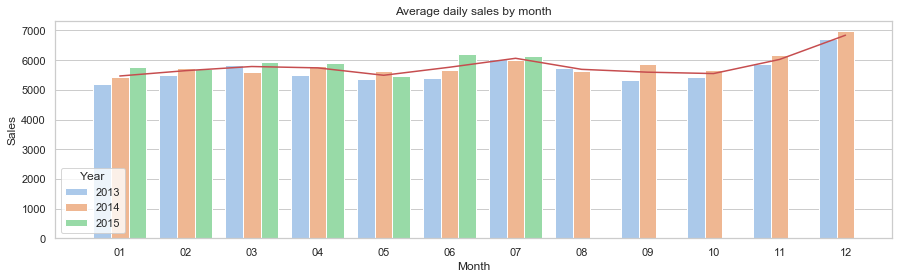

In [12]:
plt.figure(figsize=(15, 4))
data_train_m = data_train.copy()
data_train_m['Year'] = data_train_m['Date'].dt.strftime('%Y')
data_train_m['Month'] = data_train_m['Date'].dt.strftime('%m')
data_train_m = data_train_m.groupby(['Year', 'Month']).mean().reset_index()
sns.barplot(x='Month', y='Sales', hue='Year', palette='pastel', data=data_train_m)
data_train_m = data_train_m.groupby(['Month']).mean().reset_index()
ax = sns.lineplot(x=data_train_m.index, y=data_train_m['Sales'], color='#c64d4f')
ax.set_title('Average daily sales by month')
ax.legend_.set_title('Year')
plt.show()

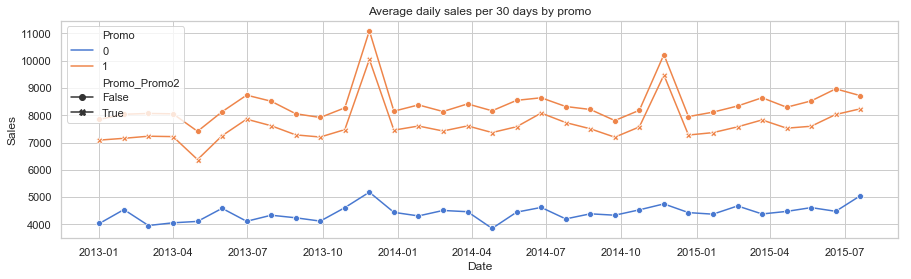

In [13]:
plt.figure(figsize=(15, 4))
data_train_ = data_train.copy()
data_train_ = data_train_[['Sales', 'Date', 'Promo', 'Promo2']]
data_train_['Promo_Promo2'] = data_train_['Promo'] & data_train_['Promo2']
data_train_ = data_train_.groupby([pd.Grouper(key='Date', freq='30D'), 'Promo', 'Promo_Promo2']).mean().reset_index()
ax = sns.lineplot(x='Date', y='Sales', hue='Promo', style='Promo_Promo2', data=data_train_, markers=True, dashes=False)
ax.set_title('Average daily sales per 30 days by promo')
plt.show()

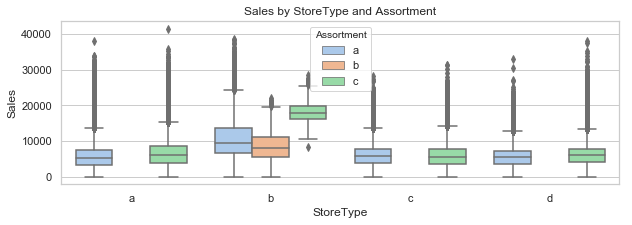

In [14]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(x='StoreType', y='Sales', hue='Assortment', palette='pastel', data=data_train)
ax.set_title('Sales by StoreType and Assortment')
plt.show()

## 数据预处理

In [1]:
from utils import preprocessing, cv, model
from sklearn.externals import joblib
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

data_train, data_test, data_store = preprocessing.read_csv(['data/train.csv', 'data/test.csv', 'data/store.csv'])
data_train = preprocessing.combine(data_train, data_store)
data_test = preprocessing.combine(data_test, data_store)
(X_train, y_train), X_test = preprocessing.transform(data_train, data_test)

In [2]:
X_train

,Store,DayOfWeek,Year,Month,Day,DayOfYear,WeekOfYear,Quarter,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpen,Promo2,Promo2SinceWeek,Promo2SinceYear,Promo2Open,InPromoMonth,MeanLogSalesByStore,MeanLogSalesByDOW,MeanLogSalesByMonth
0,1,4,2015,7,31,212,31,3,1,1,0,1,3,1,1270.0,9.0,2008.0,84.0,0.0,NaN,NaN,0.00,0,8.468023,2.246065,8.847155
1,2,4,2015,7,31,212,31,3,1,1,0,1,1,1,570.0,11.0,2007.0,96.0,1.0,13.0,2010.0,64.50,1,8.508132,2.246065,8.847155
2,3,4,2015,7,31,212,31,3,1,1,0,1,1,1,14130.0,12.0,2006.0,108.0,1.0,14.0,2011.0,52.25,1,8.845571,2.246065,8.847155
3,4,4,2015,7,31,212,31,3,1,1,0,1,3,3,620.0,9.0,2009.0,72.0,0.0,NaN,NaN,0.00,0,9.173614,2.246065,8.847155
4,5,4,2015,7,31,212,31,3,1,1,0,1,1,1,29910.0,4.0,2015.0,3.0,0.0,NaN,NaN,0.00,0,8.450471,2.246065,8.847155
5,6,4,2015,7,31,212,31,3,1,1,0,1,1,1,310.0,12.0,2013.0,24.0,0.0,NaN,NaN,0.00,0,8.614492,2.246065,8.847155
6,7,4,2015,7,31,212,31,3,1,1,0,1,1,3,24000.0,4.0,2013.0,27.0,0.0,NaN,NaN,0.00,0,9.084556,2.246065,8.847155
7,8,4,2015,7,31,212,31,3,1,1,0,1,1,1,7520.0,10.0,2014.0,12.0,0.0,NaN,NaN,0.00,0,8.619814,2.246065,8.847155
8,9,4,2015,7,31,212,31,3,1,1,0,1,1,3,2030.0,8.0,2000.0,180.0,0.0,NaN,NaN,0.00,0,8.789255,2.246065,8.847155
9,10,4,2015,7,31,212,31,3,1,1,0,1,1,1,3160.0,9.0,2009.0,72.0,0.0,NaN,NaN,0.00,0,8.625046,2.246065,8.847155


## 执行过程

In [4]:
params = {
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'lambda': 0.2,
    'silent': 1,
    'seed': 12
}

m = model.Model(params, num_boost_round=5000, early_stopping_rounds=50)
m.train(X_train, y_train)

[0]	eval-rmse:8.03036	train-rmse:8.02056	eval-rmspe:0.91464	train-rmspe:0.914456
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:7.79	train-rmse:7.78009	eval-rmspe:0.887239	train-rmspe:0.887012
[2]	eval-rmse:7.55709	train-rmse:7.54683	eval-rmspe:0.860689	train-rmspe:0.860391
[3]	eval-rmse:7.33126	train-rmse:7.32058	eval-rmspe:0.834944	train-rmspe:0.834569


KeyboardInterrupt: 

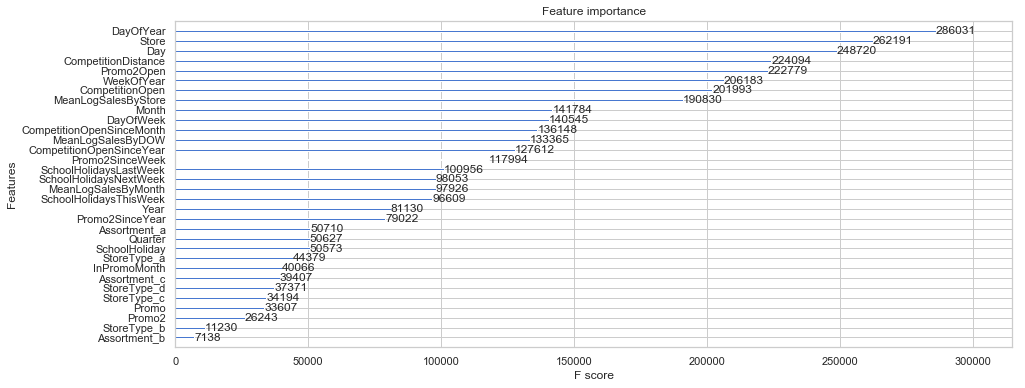

In [4]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

sns.set(style='whitegrid', palette='muted')

m.save_model('data/model.joblib.dat')

fig, ax = plt.subplots(figsize=(15, 6))
xgb.plot_importance(m.bst, ax=ax)
plt.show()

### 对测试集进行预测

选择对 _Sales_ 数据的还原缩放权重以修正预处理过程中 _np.log1p_ 可能导致的误差：

Best weight is 1.0, RMSPE is 0.1151


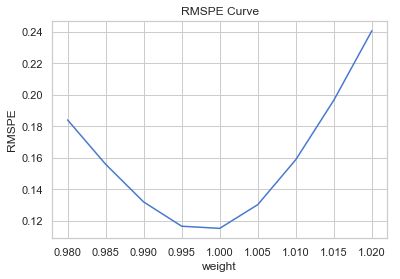

In [5]:
import xgboost as xgb

def correction(model, y_train):
    y_true, y_pred = y_train[:41088], model.bst.predict(xgb.DMatrix(X_train[:41088]))
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    
    for w in weights:
        error = cv.rmspe(np.expm1(y_true[:41088]), np.expm1(y_pred * w))
        errors.append(error)

    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction(m, y_train)

生成测试集的预测结果并保存至 CSV 文件：

In [8]:
weight = 1
y_pred = m.predict(X_test, weight=weight)

result = pd.DataFrame({'Id': data_test['Id'], 'Sales': y_pred})
result.to_csv('data/submission.csv', index=False)

### 可视化结果

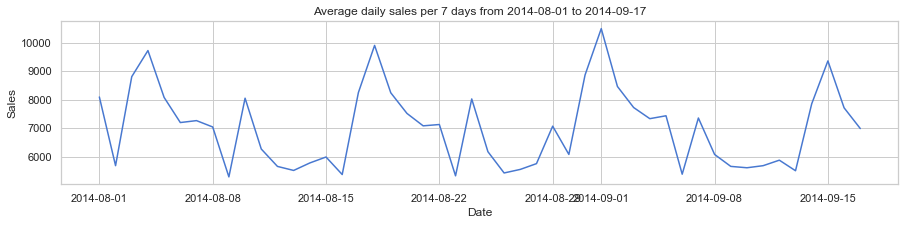

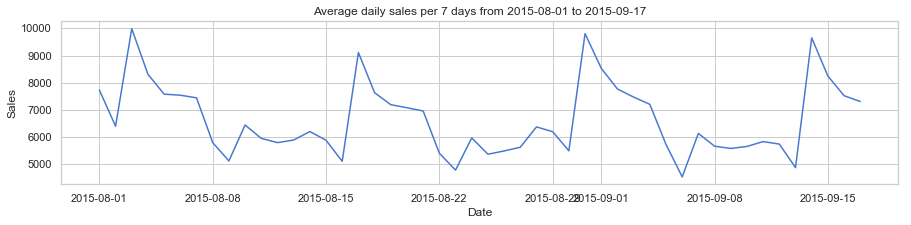

In [9]:
data_train_sales = pd.concat([X_train, np.expm1(y_train * weight)], axis=1)
data_train_sales['Date'] = pd.to_datetime(data_train_sales[['Year', 'Month', 'Day']])
data_train_sales = data_train_sales[(data_train_sales['Date'] >= '2014-08-01') & (data_train_sales['Date'] <= '2014-09-17')]
data_test_sales = pd.concat([X_test, pd.Series(y_pred, name='Sales')], axis=1)
data_test_sales['Date'] = pd.to_datetime(data_test_sales[['Year', 'Month', 'Day']])
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key='Date', freq='D')).mean()
data_test_sales_1 = data_test_sales.groupby(pd.Grouper(key='Date', freq='D')).mean()

plt.figure(figsize=(15, 3))
sns.lineplot(x=data_train_sales_1.index, y=data_train_sales_1['Sales']).set_title('Average daily sales per 7 days from 2014-08-01 to 2014-09-17')
plt.show()
plt.figure(figsize=(15, 3))
sns.lineplot(x=data_test_sales_1.index, y=data_test_sales_1['Sales']).set_title('Average daily sales per 7 days from 2015-08-01 to 2015-09-17')
plt.show()